In [13]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pmlb
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import data
REGRESSION_DSETS_LARGE_NAMES = data.REGRESSION_DSETS_LARGE_NAMES
import numpy.linalg as npl
from scipy.optimize import minimize
from process_results import process_results, aggregate_results, best_ridge
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, RidgeCV, LassoCV

%matplotlib inline
%load_ext autoreload
%autoreload 2

save_dir = 'results'
os.makedirs(save_dir, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
class p:
    seed = 15
    out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/double_descent/test'
    dset = 'gaussian' # gaussian
    beta_type = 'gaussian' # one_hot
    beta_norm = 1
    iid = 'iid' # 'iid', 'clustered', 'spike', decay
    dset_num = 1 # only matters for pmlb
    dset_name = ''
    reg_param = -1.0 # -1 use csv
    num_features = 200
    n_train_over_num_features = 0.75 # this and num_features sets n_train
    n_test = 1000
    noise_std = 1e-1
    noise_distr = 'gaussian' # gaussian, t, gaussian_scale_var, thresh
    model_type = 'ridge' # mdl_orig, 
    cov_param = 2
    
def add_results(p, r):
    # warning - this reseeds!
    p.n_train = int(n_train_over_num_features * p.num_features)
    X_train, y_train, X_test, y_test, betastar = \
        data.get_data_train_test(n_train=p.n_train, n_test=p.n_test, p=p.num_features, 
                            noise_std=p.noise_std, noise_distr=p.noise_distr, iid=p.iid, # parameters to be determined
                            beta_type=p.beta_type, beta_norm=p.beta_norm, 
                            seed_for_training_data=p.seed, cov_param=p.cov_param)

    eigenvals, eigenvecs = npl.eig(X_train.T @ X_train)
    var = p.noise_std**2

    def calc_thetahat(l):
        inv = npl.pinv(X_train.T @ X_train + l * np.eye(p.num_features))
        return inv @ X_train.T @ y_train

    def mdl1_loss(l):
        thetahat = calc_thetahat(l)
        mse_norm = npl.norm(y_train - X_train @ thetahat)**2 / (2 * var)
        theta_norm = npl.norm(thetahat)**2 / (2 * var)
        eigensum = 0.5 * np.sum(np.log((eigenvals + l) / l))
        return mse_norm + theta_norm + eigensum

    m = RidgeCV(fit_intercept=False, alphas=np.logspace(-3, 3, num=10, base=10))
    m.fit(X_train, y_train)
    
    opt_solved = minimize(mdl1_loss, x0=1e-10)
    lambda_opt = opt_solved.x
    thetahat = calc_thetahat(lambda_opt)
    r['mse_norm'][i] = npl.norm(y_train - X_train @ thetahat)**2 / (2 * var)
    r['theta_norm'][i] = npl.norm(thetahat)**2 / (2 * var)
    r['eigensum'][i] = 0.5 * np.sum(np.log((eigenvals + lambda_opt) / lambda_opt))
    
    
    for suff in ['', '_cv']:
        if suff == '_cv':
            y_pred = m.predict(X_test)
        else:
            y_pred = X_test @ thetahat
        r['mse_test' + suff][i] = np.mean(np.square(y_test - y_pred))


        _, _, X_test, y_test, betastar = \
            data.get_data_train_test(n_train=p.n_train, n_test=p.n_test, p=p.num_features, 
                                noise_std=p.noise_std, noise_distr=p.noise_distr, iid='decay', # parameters to be determined
                                beta_type=p.beta_type, beta_norm=p.beta_norm, 
                                seed_for_training_data=p.seed, cov_param=p.cov_param)
        if suff == '_cv':
            y_pred = m.predict(X_test)
        else:
            y_pred = X_test @ thetahat
        r['mse_decay' + suff][i] = np.mean(np.square(y_test - y_pred))

        _, _, X_test, y_test, betastar = \
            data.get_data_train_test(n_train=p.n_train, n_test=p.n_test, p=p.num_features, 
                                noise_std=p.noise_std, noise_distr='thresh', iid=p.iid, # parameters to be determined
                                beta_type=p.beta_type, beta_norm=p.beta_norm, 
                                seed_for_training_data=p.seed, cov_param=p.cov_param)
        if suff == '_cv':
            y_pred = m.predict(X_test)
        else:
            y_pred = X_test @ thetahat
        r['mse_thresh' + suff][i] = np.mean(np.square(y_test - y_pred))

        _, _, X_test, y_test, betastar = \
            data.get_data_train_test(n_train=p.n_train, n_test=p.n_test, p=p.num_features, 
                                noise_std=p.noise_std, noise_distr='t', iid=p.iid, # parameters to be determined
                                beta_type=p.beta_type, beta_norm=p.beta_norm, 
                                seed_for_training_data=p.seed, cov_param=p.cov_param)
        if suff == '_cv':
            y_pred = m.predict(X_test)
        else:
            y_pred = X_test @ thetahat
        r['mse_t' + suff][i] = np.mean(np.square(y_test - y_pred))


    return r

# vary p/n

In [28]:
n_train_over_num_features_list = np.array([1e-2, 5e-2, 1e-1, 0.5, 0.75, 0.9, 1,
                                           1.2, 1.5, 2, 5, 7.5, 1e1, 2e1, 4e1, 1e2])
n = n_train_over_num_features_list.size
r = {
    'mse_norm': np.zeros(n),
    'theta_norm': np.zeros(n),
    'eigensum': np.zeros(n),
    'mse_test': np.zeros(n),
    'mse_decay': np.zeros(n),
    'mse_thresh': np.zeros(n),
    'mse_t': np.zeros(n),    
    'mse_test_cv': np.zeros(n),
    'mse_decay_cv': np.zeros(n),
    'mse_thresh_cv': np.zeros(n),
    'mse_t_cv': np.zeros(n),    
}

for i, n_train_over_num_features in tqdm(enumerate(n_train_over_num_features_list)):
    p.n_train_over_num_features = n_train_over_num_features
    # p.n_train = int(n_train_over_num_features * p.num_features)
    r = add_results(p, r)
    
r['loss_val'] = r['mse_norm'] + r['theta_norm'] + r['eigensum']


0it [00:00, ?it/s]/accounts/projects/vision/.local/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/accounts/projects/vision/.local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:172: ComplexWarning: Casting complex values to real discards the imaginary part
  amin, amax, isave, dsave)
/accounts/projects/vision/.local/lib/python3.7/site-packages/ipykernel_launcher.py:50: ComplexWarning: Casting complex values to real discards the imaginary part

1it [00:01,  1.19s/it]/accounts/projects/vision/.local/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/accounts/projects/vision/.local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:172: ComplexWarning: Casting complex values to real discards the imaginary

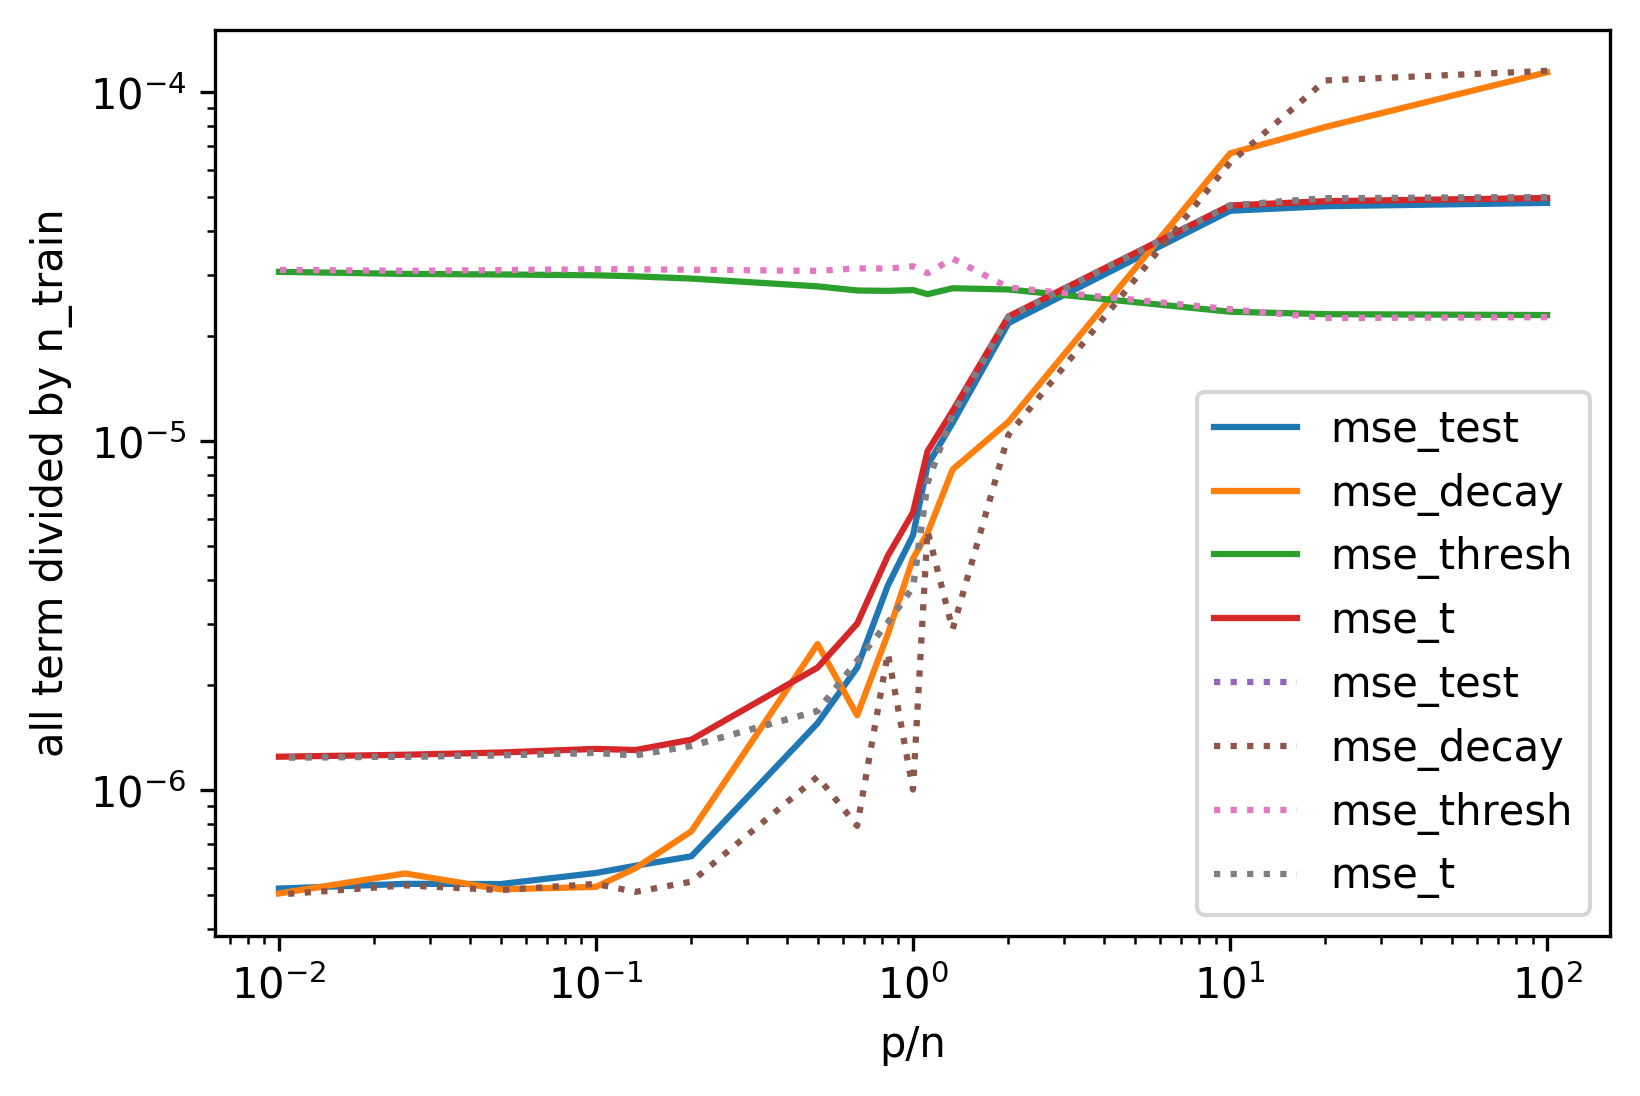

In [29]:
plt.figure(dpi=300)
def norm(x):
    return x / n_train_over_num_features / p.num_features
# plt.plot(1/n_train_over_num_features_list, norm(r['loss_val']), label='loss')
# plt.plot(1/n_train_over_num_features_list, norm(r['mse_norm']), label='mse_norm')
# plt.plot(1/n_train_over_num_features_list, norm(r['theta_norm']), label='theta_norm')
# plt.plot(1/n_train_over_num_features_list, norm(r['eigensum']), label='eigensum')

plt.plot(1/n_train_over_num_features_list, norm(r['mse_test']), label='mse_test')
plt.plot(1/n_train_over_num_features_list, norm(r['mse_decay']), label='mse_decay')
plt.plot(1/n_train_over_num_features_list, norm(r['mse_thresh']), label='mse_thresh')
plt.plot(1/n_train_over_num_features_list, norm(r['mse_t']), label='mse_t')

plt.plot(1/n_train_over_num_features_list, norm(r['mse_test_cv']), ':', label='mse_test')
plt.plot(1/n_train_over_num_features_list, norm(r['mse_decay_cv']), ':', label='mse_decay')
plt.plot(1/n_train_over_num_features_list, norm(r['mse_thresh_cv']), ':', label='mse_thresh')
plt.plot(1/n_train_over_num_features_list, norm(r['mse_t_cv']), ':', label='mse_t')
plt.xscale('log')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('p/n')
plt.ylabel('all term divided by n_train')
plt.legend()
plt.show()